In [70]:
# import necessary packages
import os
import seaborn as sns
import pandas as pd
import pingouin as pg
import numpy as np
from tqdm import tqdm
from IPython.display import display
from random import choices
import pickle

import scipy.stats as st
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
from matplotlib.colors import ListedColormap

from nilearn.connectome import ConnectivityMeasure

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, LeaveOneOut, KFold
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score

In [51]:
# here are the functions which we use later
def load_timeseries_roi(ts_files,subjid_kept,keepgs=True,standardise=True):
    timeseries = []
    perc_scrubbed = []
    loadedsubjpath = []
    for i, f in enumerate(ts_files):

        if i in subjid_kept:
            print('This is the ordered ID of our included participant:' + str(i)+'\nthis is the file what we read in:\n' + f)
            print('-'*65)

            if keepgs:
                ts = pd.read_csv(f, sep="\t") #keep the global signal
                labels = pd.read_csv(ts_files[0], sep="\t").columns
            else:
                ts = pd.read_csv(f, sep="\t").drop('GlobSig', 1).values # delet the global signal
                labels = pd.read_csv(ts_files[0], sep="\t").columns[1:]
            ts_pd=pd.DataFrame(ts)
            loadedsubjpath.append(f)
        # standardise timeseries
            if standardise:
                ts = StandardScaler().fit_transform(ts)
            else:
                ts = np.array(ts)

            timeseries.append(ts)
        else:
            print('We do not include participant with:\t'+str(i)+'\torderedID\n who has the following path:'+f)
            print('-'*65)

    labels = pd.read_csv(ts_files[0], sep="\t").columns
    return timeseries, labels, ts_pd, loadedsubjpath

def connectivity_matrix(timeseries, roilabelid,kind='partial correlation',vect=True,allroi=True,covest=LedoitWolf()):
    # timeseries: as output by load_timeseries
    correlation_measure = ConnectivityMeasure(kind=kind, vectorize=vect, discard_diagonal=True)
    correlation_measure.cov_estimator = covest
    if allroi:
        correlation_matrix = correlation_measure.fit_transform(timeseries)
        print('we calculated the ',kind, 'between allroi.')
    else:
        templist=list()
        for i in range(0,len(timeseries)):
            timeseries[i] = timeseries[i][:,roilabelid]

        correlation_matrix = correlation_measure.fit_transform(timeseries)
    return correlation_matrix, correlation_measure

def pipe_scale_fsel_ridge_noscaler( fsel=SelectKBest(f_regression),
                          model=Ridge(max_iter=100000),
                        #p_grid = {'fsel__k': [20, 25, 30, 35, 40, 45, 50, 60, 70, 80], 'model__alpha': [.001, .005, .01, .05, .1, .5]} # for fast re-calculation
                        p_grid = {'fsel__k': np.linspace(10, 200, 39,dtype=int), 'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 10]} # exhaustive, takes a lot of time
                          ):
    mymodel = Pipeline(
        [ ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

def mytrain(X, y, model, p_grid, nested=False, score="neg_mean_squared_error",model_averaging=True ):

    inner_cv = LeaveOneOut()
    outer_cv = LeaveOneOut() #KFold(n_splits=10)
    predicted = np.array([])

    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                       scoring=score, verbose=False, return_train_score=False, n_jobs=10,refit=True)
                      #pre_dispatch=6)
    clf.fit(X, y)

    print("**** Non-nested analysis ****")
    print ("** Best hyperparameters: " + str(clf.best_params_))

    print ("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
    print( "** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
    print ("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))

    model=clf.best_estimator_

    print("XXXXX Explained Variance: " + str(1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))

    avg_model = None
    all_models = []
    if nested:
        print ("**** Nested analysis ****")

        #nested_scores = cross_val_score(clf, X, y, cv=outer_cv, scoring="explained_variance")
        #print "** Nested Score on test:\t" + str(nested_scores.mean())
        # this above has the same output as this below:

        best_params = []
        predicted = np.zeros(len(y))
        actual = np.zeros(len(y))
        nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
        nested_scores_test = np.zeros(outer_cv.get_n_splits(X))
        nested_scores_test2 = np.zeros(outer_cv.get_n_splits(X))
        i = 0
        avg = []
        # doing the crossval itewrations manually
        print ("model\tinner_cv mean score\touter vc score")
        for train, test in outer_cv.split(X, y):
            clf.fit(X[train], y[train])

            # model avaraging
            #RES, mat, labels = get_full_coef(X[train], clf.best_estimator_, plot=False)
            #avg.append(RES)
            all_models.append(clf.best_estimator_)
            # plot histograms to check distributions
            #bins = np.linspace(-1.5, 1.5, 6)
            #pyplot.hist(y[train], bins, alpha=0.5, label='train')
            #pyplot.hist(y[test], bins, alpha=0.5, label='test')
            #pyplot.legend(loc='upper right')
            #pyplot.show()

            print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
            predicted[i] = clf.predict(X[test])
            actual[i] = y[test]

            best_params.append(clf.best_params_)
            nested_scores_train[i] = clf.best_score_
            nested_scores_test[i] = clf.score(X[test], y[test])
            # clf.score is the same as calculating the score to the prediced values of the test dataset:
            #nested_scores_test2[i] = explained_variance_score(y_pred=clf.predict(X[test]), y_true=y[test])
            i = i+1

        print ("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
        print ("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
        print ("** Std score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.std()))
        print ("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
        print ("** Std Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.std()))

        print ("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
        print ("Correlation: " + str(np.corrcoef(actual, predicted)[0,1]))

        avg_model = np.mean(np.array(avg), axis=0)

        #plot the prediction of the outer cv
        fig, ax = plt.subplots()
        ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
       # ax.plot([y.min(), y.max()],
        #           [y.min(), y.max()],
         #          'k--',
          #         lw=2)
        ax.set_xlabel('Observed value')
        ax.set_ylabel('Predicted (Nested LOO)')
        plt.title("Expl. Var.:" +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ) +
        "\nCorrelation: " + str(np.corrcoef(actual, predicted)[0, 1]) )
        plt.show()
    else:
        all_models = [model]
        fig = []

    model.fit(X, y) # fit to whole data

    return model, avg_model, all_models, clf, fig, predicted

def evaluate_crossval_prediction(model, X, y, outfile="", cv=LeaveOneOut(), robust=False):
    predicted = cross_val_predict(model, X, y, cv=cv)
    p_value, r_2, residual, regline = pred_stat(y, predicted, robust=robust)

    expl_var = ( 1- (-mean_squared_error(y_pred=predicted, y_true=y)
                   /
                   -mean_squared_error(np.repeat(y.mean(), len(y)), y) ))*100

    print ("R2=" + "{:.3f}".format(r_2) + "  R=" + "{:.3f}".format(np.sqrt(r_2)) \
          + "   p=" + "{:.6f}".format(p_value) + "  Expl. Var.: " + "{:.1f}".format(expl_var) + "%" \
          + "  Expl. Var.2: " + "{:.1f}".format(explained_variance_score(y_pred=predicted, y_true=y)*100) + "%" \
          + "  MSE=" + "{:.3f}".format(mean_squared_error(y_pred=predicted, y_true=y)) \
          + " RMSE=" + "{:.3f}".format(np.sqrt(mean_squared_error(y_pred=predicted, y_true=y))) \
          + "  MAE=" + "{:.3f}".format(mean_absolute_error(y_pred=predicted, y_true=y)) \
          + " MedAE=" + "{:.3f}".format(median_absolute_error(y_pred=predicted, y_true=y)) \
          + "  R^2=" + "{:.3f}".format(r2_score(y_pred=predicted, y_true=y)))


    plot_prediction(y, predicted, outfile, robust=robust, sd=True,
                         text="$R2$=" + "{:.3f}".format(r_2) +
                              "  p=" + "{:.3f}".format(p_value) +
                              "  Expl. Var.: " + "{:.1f}".format(expl_var) + "%"
                         )
    return predicted

def plot_prediction(observed, predicted, outfile="", covar=[], robust=False, sd=True, text=""):
    color = "black"
    if len(covar):
        g = sns.jointplot(observed, predicted, scatter=False, color=color, kind="reg", robust=robust, x_ci="sd", )
        plt.scatter(observed, predicted,
                    c=covar, cmap=ListedColormap(sns.color_palette(["#5B5BFF","#D73E68"])))
    else:
        g = sns.jointplot(observed, predicted, kind="reg", color=color, robust=robust, x_ci="sd")
    #sns.regplot(observed, predicted, color="b", x_bins=10, x_ci=None)



    if sd:
        xlims=np.array(g.ax_joint.get_xlim())
        if robust:
            res = sm.RLM(predicted, sm.add_constant(observed)).fit()
            coefs = res.params
            residual = res.resid
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(observed, predicted)
            coefs=[intercept, slope]
            regline = slope * observed + intercept
            residual = observed - regline

        S = np.sqrt(np.mean(residual**2))
        upper = coefs[1] * xlims + coefs[0] + S/2
        lower = coefs[1] * xlims + coefs[0] - S/2

        plt.plot(xlims, upper, ':', color=color, linewidth=1, alpha=0.3)
        plt.plot(xlims, lower, ':', color=color, linewidth=1, alpha=0.3)

    if text:
        plt.text(np.min(observed) - (np.max(predicted)-np.min(predicted))/3,
                 np.max(predicted) + (np.max(predicted)-np.min(predicted))/3,
                 text, fontsize=10)

    if outfile:
        figure = plt.gcf()
        figure.savefig(outfile, bbox_inches='tight')
        plt.close(figure)
    else:
        plt.show()

def pred_stat(observed, predicted, robust=False):

    # convert to np.array
    observed = np.array(observed)
    predicted = np.array(predicted)

    #EXCLUDE NA-s:
    predicted = predicted[~np.isnan(observed)]
    observed = observed[~np.isnan(observed)]

    if robust:
        res = sm.RLM(observed, sm.add_constant(predicted)).fit()
        p_value = res.pvalues[1]
        regline = res.fittedvalues
        residual = res.sresid

        # this is a pseudo r_squared, see: https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels
        r_2 = sm.WLS(observed, sm.add_constant(predicted), weights=res.weights).fit().rsquared

    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(observed, predicted)
        regline = slope*observed+intercept
        r_2 = r_value**2
        residual = observed - regline

    return p_value, r_2, residual, regline

In [52]:
# define paths
# for subjectID (to map the RPN and original subject ID)
# Load the sujectID file from the RPN output to easliy pair the indices with the appropriate participants:
subjID_idx = pd.read_csv('/home/balint/Documents/Katistudy/rpnresults/subjectsIDs.txt',header=None)
# motion information
motioninf = pd.read_csv("/home/balint/Documents/Katistudy/rpnresults/motion_summary.csv")

# define path to the timeseries data
ts_directory = "/home/balint/Documents/Katistudy/rpnresults/timeseries/"
#add label information from the used MIST atlas
labelinf = pd.read_csv('/home/balint/DATA/MIST_atlas/Parcel_Information/MIST_122.csv',sep=';')

In [53]:
# define subject IDs for exclusion(missing values, fall asleep) and values for exclusion
# collect all the particpants subjID who we would like to exclude and include based on the info from the measurement and the motion info
# we exclude three of them because:
# -subj 8 felt asleep in the scanner
# -subj 18 - missing behavior data (bad eyesight)
# -subj 31 - missing mri data (basically we do not have to exclude him but for the sake of fullness)
excl_subnum = [8, 18,31]
#define motion limits
FDlimit = 0.15
percscrublimit = 25

In [54]:
# create a dictionary in which the keys are the subject IDs defined in the study and the values are the ids in the RPN(the output simple an increasing
dict_subjID_idx={}
for idx, my_string in enumerate(subjID_idx[0].values):
    dict_subjID_idx[np.int((my_string.split("func/sub-",1)[1].split('_task',1)[0]))] = idx
# exclude subject based on measurement info
excl_indices = list(dict_subjID_idx[k] for k in excl_subnum if k in dict_subjID_idx.keys())


orderidx_incl = motioninf.loc[(motioninf['meanFD'] < FDlimit) &
                              (motioninf['perc_scrubbed'] < percscrublimit) &
                                #(motioninf['maxFD'] < 1) &
                              (~motioninf['Unnamed: 0'].isin(excl_indices)) ,:].index.values
dict_subjID_idx_incl = {}
dict_subjID_idx_excl = {}
for key, value in dict_subjID_idx.items():
    if value in orderidx_incl:
        dict_subjID_idx_incl[key]=value
    else:
        dict_subjID_idx_excl[key]=value
print('These are the subjects subjectID who were excluded:\t' + str(dict_subjID_idx_excl.keys()))
print('These are the subjects ordererID who were excluded:\t' + str(dict_subjID_idx_excl.values()))
print('These are the subjects subjectID who were included:\t' + str(dict_subjID_idx_incl.keys()))
print('These are the subjects ordererID who were included:\t' + str(dict_subjID_idx_incl.values()))
print('In total we work with\t'+ str(len(orderidx_incl)) + '\t participants.\n Check if all the aprticipanst have behavior data!!!!')
nexclbasedonmotion = len(subjID_idx) - len(excl_indices) - len(orderidx_incl)
print('Number of participant excluded based in the motion parameters(FD>' +str(FDlimit)+ ',scrubbed percent>' +str(percscrublimit)+'):' +str(nexclbasedonmotion))
for key, value in dict_subjID_idx.items():
    if value in motioninf.drop(orderidx_incl)['Unnamed: 0']:
        print('this is their subjID \t'+str(key)+'\tand this is thier orderID:\t'+str(value))
print('These are the participants subjID whose excluded beforehand:\t' + str(excl_subnum))

These are the subjects subjectID who were excluded:	dict_keys([4, 7, 8, 14, 16, 18, 22, 24, 25, 29, 36, 43, 44])
These are the subjects ordererID who were excluded:	dict_values([1, 3, 4, 7, 9, 11, 15, 17, 18, 21, 26, 33, 34])
These are the subjects subjectID who were included:	dict_keys([3, 5, 9, 12, 15, 17, 19, 20, 21, 23, 27, 28, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 47])
These are the subjects ordererID who were included:	dict_values([0, 2, 5, 6, 8, 10, 12, 13, 14, 16, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 36, 37])
In total we work with	25	 participants.
 Check if all the aprticipanst have behavior data!!!!
Number of participant excluded based in the motion parameters(FD>0.15,scrubbed percent>25):11
this is their subjID 	4	and this is thier orderID:	1
this is their subjID 	7	and this is thier orderID:	3
this is their subjID 	8	and this is thier orderID:	4
this is their subjID 	14	and this is thier orderID:	7
this is their subjID 	16	and this is thier orderID:

/tmp/ipykernel_45543/1268904467.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dict_subjID_idx[np.int((my_string.split("func/sub-",1)[1].split('_task',1)[0]))] = idx


In [55]:
# define timeseries path
ts_filelist=os.listdir(ts_directory)
ts_filelist.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
ts_fullpathfs=[]
for ff in ts_filelist:
    ts_fullpathfs.append(os.path.join(ts_directory,ff))
print('These are the paths to the mri timeseries file:')
ts_fullpathfs

These are the paths to the mri timeseries file:


['/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_00_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_01_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_02_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_03_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_04_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_05_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_06_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_07_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_08_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_09_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_10_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_11_ts.tsv',
 '/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_12_ts.tsv',
 '/home/balint/Documents/Katistudy/rpn

In [56]:
# load timeseries file

ts, labels, examplets_pd, loadedsubj = load_timeseries_roi(ts_fullpathfs,dict_subjID_idx_incl.values(),
                                                   keepgs=True,standardise=True)

This is the ordered ID of our included participant:0
this is the file what we read in:
/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_00_ts.tsv
-----------------------------------------------------------------
We do not include participant with:	1	orderedID
 who has the following path:/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_01_ts.tsv
-----------------------------------------------------------------
This is the ordered ID of our included participant:2
this is the file what we read in:
/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_02_ts.tsv
-----------------------------------------------------------------
We do not include participant with:	3	orderedID
 who has the following path:/home/balint/Documents/Katistudy/rpnresults/timeseries/subj_03_ts.tsv
-----------------------------------------------------------------
We do not include participant with:	4	orderedID
 who has the following path:/home/balint/Documents/Katistudy/rpnresults/timeseries

In [57]:
# The issue is that the order in the vectorized form of the connectivity matrix is not known.
# With this custom built modul we solve this:
# one has to define the number of predictors to determine the vectorized format of the connectivity matricies
numberofpredictors=np.int(((len(labels)*len(labels))-len(labels))/2)
pairofrois=np.zeros(shape=(numberofpredictors,2),dtype=int)
i=0
for ff in range(0,len(labels)):
    for gg in range(0,ff):
        pairofrois[i]= [gg,ff]
        i=i+1

# we tested it and it works. That is, the place in the vectorized matrix and the place in the variable of pairofrois
# is the same. while the former is the exact correlation value, the latter is the labels of ROIs
# so call as roilabels[pairofrois[z]]
vectorzedlabels = []
listoflabelpairs = []
for ii in pairofrois:
    vectorzedlabels.append(labels[ii][0]+'+'+labels[ii][1])
    listoflabelpairs.append([labels[ii][0],labels[ii][1]])
# checked again and it works properly. So in the vectorized format and the matrix format the certain cells match.
print(len(listoflabelpairs))

7503


/tmp/ipykernel_45543/2672382983.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numberofpredictors=np.int(((len(labels)*len(labels))-len(labels))/2)


In [58]:
# calculate the connectivity matricies for all the individual who we include.
X, cm = connectivity_matrix(ts,roilabelid= True,
                                    kind='partial correlation',
                                    vect=True,
                                    allroi=True)
data_conn = pd.DataFrame(X,
            columns=(vectorzedlabels),
            index = dict_subjID_idx_incl.keys())

we calculated the  partial correlation between allroi.


In [59]:
# get the demograhpical data
contingencyvals_list= ['sub','sex','age','acqkon_CS_tone_transf', 'acqkon_CS_pain_transf',
       'acqkon_CS_minus_transf', 'extkon_CS_tone_transf',
       'extkon_CS_pain_transf', 'extkon_CS_minus_transf',
                       'hab_UCS_pain_vas', 'hab_UCS_tone_vas',
                       'PASS_D1', 'PASS_D2', 'PASS_D3', 'PASS_D4', 'PCS', 'ADS'
                       ]
contingencyrat = pd.read_csv('/home/balint/Documents/Katistudy/C_statistics/data/df_allsubs.csv',
                             usecols=contingencyvals_list,
                             index_col='sub')
contingencyrat_incl = contingencyrat.loc[dict_subjID_idx_incl.keys(),:]
contingencyrat_incl.head()

,sex,age,hab_UCS_pain_vas,hab_UCS_tone_vas,acqkon_CS_tone_transf,acqkon_CS_pain_transf,acqkon_CS_minus_transf,extkon_CS_tone_transf,extkon_CS_pain_transf,extkon_CS_minus_transf,PASS_D1,PASS_D2,PASS_D3,PASS_D4,PCS,ADS
sub,,,,,,,,,,,,,,,,
3,2,21,22,29,90,0,8,90,62,6,1.000000,0.8,0.25,0.2,12.0,2.0
5,2,31,39,65,100,90,4,80,48,0,3.666667,2.2,3.25,2.4,34.0,11.0
9,1,25,77,58,70,68,0,38,34,0,3.000000,2.2,0.75,2.2,22.0,3.0
12,1,32,80,77,0,-2,0,2,-2,-2,3.000000,2.4,0.25,1.4,25.0,7.0
15,1,25,59,68,68,66,0,4,28,2,3.333333,2.2,1.75,1.2,25.0,4.0


In [60]:
# In this part we load our data in pandas format and identify behvaior variables which might be important
# The alldata.csv was saved from the last file which was sent by Kati(that was an .Rda file so I loaded it in R and saved a csv).
col_list1 = ['sub','sex', 'age','hpt','CS','valence','timepoint_phase', 'timepoint_phase2', 'phase','anxiety_pain',
       'anxiety_tone', 'diff_anxiety']
alldata = pd.read_csv('/home/balint/Documents/Katistudy/C_statistics/alldata.csv',
                      usecols=col_list1,
                      index_col='sub')
# get a table which include all the participants derived behavior data
alldata_behav = alldata.pivot_table(index=['sub'],
                                    values=['hpt','sex', 'age','anxiety_pain','anxiety_tone', 'diff_anxiety'])
alldata_behav_incl = alldata_behav.loc[dict_subjID_idx_incl.keys(),:]

# Reorganize the data in a wide format (long to wide) to get valence rating in an organized way
valencedata_wide = alldata.pivot_table(index=['sub'], columns=['phase','CS','timepoint_phase'],
                                       values='valence')
#get the multilevel indexing names in the columns:
print(valencedata_wide.columns.get_level_values)
valencedata_wide_excl = valencedata_wide.loc[dict_subjID_idx_incl.keys(),:]
alldata_behav_incl.head()

<bound method MultiIndex.get_level_values of MultiIndex([('acq', 'minus', 1),
            ('acq', 'minus', 2),
            ('acq', 'minus', 3),
            ('acq', 'minus', 4),
            ('acq',  'pain', 1),
            ('acq',  'pain', 2),
            ('acq',  'pain', 3),
            ('acq',  'pain', 4),
            ('acq',  'tone', 1),
            ('acq',  'tone', 2),
            ('acq',  'tone', 3),
            ('acq',  'tone', 4),
            ('ext', 'minus', 1),
            ('ext', 'minus', 2),
            ('ext', 'minus', 3),
            ('ext',  'pain', 1),
            ('ext',  'pain', 2),
            ('ext',  'pain', 3),
            ('ext',  'tone', 1),
            ('ext',  'tone', 2),
            ('ext',  'tone', 3),
            ('hab', 'minus', 0),
            ('hab',  'pain', 0),
            ('hab',  'tone', 0)],
           names=['phase', 'CS', 'timepoint_phase'])>


,age,anxiety_pain,anxiety_tone,diff_anxiety,hpt,sex
sub,,,,,,
3,21,47,14,33,44.67,2
5,31,56,17,39,44.00,2
9,25,64,13,51,44.90,1
12,32,28,34,-6,43.93,1
15,25,49,30,19,46.53,1


In [61]:
# create new behavior variables, and save them in the alldata_behav df. examples:
##########################################################
######################### ACQUISITION ####################
##########################################################
# pain learning based on my defintion in acquisition phase
alldata_behav_incl.loc[:,'y_valpainlearn_acq']=\
(valencedata_wide_excl.loc[:,('acq','pain',4)]-valencedata_wide_excl.loc[:,('hab','pain',0)])-\
(valencedata_wide_excl.loc[:,('acq','minus',4)]- valencedata_wide_excl.loc[:,('hab','minus',0)])
# tone learning based on my definition in acquisition phase
alldata_behav_incl.loc[:,'y_valtonelearn_acq']=\
(valencedata_wide_excl.loc[:,('acq','tone',4)]-valencedata_wide_excl.loc[:,('hab','tone',0)])-\
(valencedata_wide_excl.loc[:,('acq','minus',4)]- valencedata_wide_excl.loc[:,('hab','minus',0)])
# fear learning, solely include the CS pain valence rating
alldata_behav_incl.loc[:,'y_valpainlearn_onlypain_acq']=\
(valencedata_wide_excl.loc[:,('acq','pain',4)]-valencedata_wide_excl.loc[:,('hab','pain',0)])
# fear learning solely include the CS tone valence ratings
alldata_behav_incl.loc[:,'y_valtonelearn_onlytone_acq']=\
(valencedata_wide_excl.loc[:,('acq','tone',4)]-valencedata_wide_excl.loc[:,('hab','tone',0)])
# safety learning, solely include the CS neutral valence ratings
alldata_behav_incl.loc[:,'y_safetylearning_acq']=\
(valencedata_wide_excl.loc[:,('acq','minus',4)]- valencedata_wide_excl.loc[:,('hab','minus',0)])
# all CS learn
alldata_behav_incl.loc[:,'y_valpaintoneminus_learn_acq']=\
(valencedata_wide_excl.loc[:,('acq','pain',4)]-valencedata_wide_excl.loc[:,('hab','pain',0)])-\
(valencedata_wide_excl.loc[:,('acq','minus',4)]- valencedata_wide_excl.loc[:,('hab','minus',0)])+\
(valencedata_wide_excl.loc[:,('acq','tone',4)]-valencedata_wide_excl.loc[:,('hab','tone',0)])
# fear learning only subtract the end of acquisition safety and cspain valence values(not include habituation valence ratings)
alldata_behav_incl.loc[:,'y_valpainlearn_noHAB_acq']=\
(valencedata_wide_excl.loc[:,('acq','pain',4)])-\
(valencedata_wide_excl.loc[:,('acq','minus',4)])

##########################################################
######################### EXTINCTION #####################
##########################################################
# valence change in the extinction (calculated from the last valence rating of acquisition phase)
alldata_behav_incl.loc[:,'y_valpainlearn_lastacq_ext']=\
(valencedata_wide_excl.loc[:,('ext','pain',3)]-valencedata_wide_excl.loc[:,('acq','pain',4)])-\
(valencedata_wide_excl.loc[:,('ext','minus',3)]- valencedata_wide_excl.loc[:,('acq','minus',4)])
# valence change in the extinction (calculated from the last valence rating of acquisition phase)
alldata_behav_incl.loc[:,'y_valtonelearn_lastacq_ext']=\
(valencedata_wide_excl.loc[:,('ext','tone',3)]-valencedata_wide_excl.loc[:,('acq','tone',4)])-\
(valencedata_wide_excl.loc[:,('ext','minus',3)]- valencedata_wide_excl.loc[:,('acq','minus',4)])
# valence change solely on the pain valnce change(not contrasted to the neutral stimulus)
alldata_behav_incl.loc[:,'y_valpainlearn_onlypain_lastacq_ext']=\
(valencedata_wide_excl.loc[:,('ext','pain',3)]-valencedata_wide_excl.loc[:,('acq','pain',4)])
# solely tone learning during extinction
alldata_behav_incl.loc[:,'y_valtonelearn_onlytone_lastacq_ext']=\
(valencedata_wide_excl.loc[:,('ext','tone',3)]-valencedata_wide_excl.loc[:,('acq','tone',4)])
# safety learning, solely include the CS neutral valence ratings
alldata_behav_incl.loc[:,'y_safetylearning_ext']=\
(valencedata_wide_excl.loc[:,('ext','minus',3)]- valencedata_wide_excl.loc[:,('acq','minus',4)])
#alldata_behav_incl.head()

In [62]:
# contingency ratings for the different stimuli
# CSpain cont in acquisition
alldata_behav_incl.loc[:,'y_paincont_acq']=\
contingencyrat_incl.loc[:,'acqkon_CS_pain_transf']
# CStone cont in acquisition
alldata_behav_incl.loc[:,'y_tonecont_acq']=\
contingencyrat_incl.loc[:,'acqkon_CS_tone_transf']
#CS minus cont in acquisition
alldata_behav_incl.loc[:,'y_safetycont_acq']=\
contingencyrat_incl.loc[:,'acqkon_CS_minus_transf']
# CSpain cont in extinction
alldata_behav_incl.loc[:,'y_paincont_ext']=\
contingencyrat_incl.loc[:,'extkon_CS_pain_transf']
# CStone cont in extinction
alldata_behav_incl.loc[:,'y_tonecont_ext']=\
contingencyrat_incl.loc[:,'extkon_CS_tone_transf']
#CS minus cont in extinction
alldata_behav_incl.loc[:,'y_safetycont_ext']=\
contingencyrat_incl.loc[:,'extkon_CS_minus_transf']

In [63]:
# other secondary outcome variables
alldata_behav_incl=alldata_behav_incl.join(contingencyrat_incl[['hab_UCS_pain_vas', 'hab_UCS_tone_vas','PASS_D1', 'PASS_D2', 'PASS_D3', 'PASS_D4', 'PCS', 'ADS']])

In [64]:
print(alldata_behav_incl.columns)
yvar = 'y_valpainlearn_acq'
X_predictor = data_conn.to_numpy()
print('The shape of our predictor matrix:',X_predictor.shape)
y_predictor = alldata_behav_incl[yvar].to_numpy()
#y_predictor = behavforcorr['medianFD'].values

print('The shape of our outcome variable:', y_predictor.shape)

Index(['age', 'anxiety_pain', 'anxiety_tone', 'diff_anxiety', 'hpt', 'sex',
       'y_valpainlearn_acq', 'y_valtonelearn_acq',
       'y_valpainlearn_onlypain_acq', 'y_valtonelearn_onlytone_acq',
       'y_safetylearning_acq', 'y_valpaintoneminus_learn_acq',
       'y_valpainlearn_noHAB_acq', 'y_valpainlearn_lastacq_ext',
       'y_valtonelearn_lastacq_ext', 'y_valpainlearn_onlypain_lastacq_ext',
       'y_valtonelearn_onlytone_lastacq_ext', 'y_safetylearning_ext',
       'y_paincont_acq', 'y_tonecont_acq', 'y_safetycont_acq',
       'y_paincont_ext', 'y_tonecont_ext', 'y_safetycont_ext',
       'hab_UCS_pain_vas', 'hab_UCS_tone_vas', 'PASS_D1', 'PASS_D2', 'PASS_D3',
       'PASS_D4', 'PCS', 'ADS'],
      dtype='object')
The shape of our predictor matrix: (25, 7503)
The shape of our outcome variable: (25,)


**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 30, 'model__alpha': 0.005}
** Score on full data as training set:	-1.0521850391342011
** Score on mean as model: -543.4399999999999
** Best Non-nested cross-validated score on test:	-320.58734778131196
XXXXX Explained Variance: 0.41007774955595466
**** Nested analysis ****
model	inner_cv mean score	outer vc score
{'fsel__k': 30, 'model__alpha': 0.001} -429.6771098710048 -461.7373455149988
{'fsel__k': 30, 'model__alpha': 0.001} -345.414306580669 -195.2439336596395
{'fsel__k': 40, 'model__alpha': 0.001} -456.8376926602004 -180.93994611304544
{'fsel__k': 40, 'model__alpha': 0.001} -397.2534493944215 -869.8527555363278
{'fsel__k': 40, 'model__alpha': 0.001} -378.6260605637852 -10.695561863718014
{'fsel__k': 30, 'model__alpha': 0.005} -447.9470352525797 -215.18820066625887
{'fsel__k': 20, 'model__alpha': 0.005} -358.4506576529325 -381.3689560370901
{'fsel__k': 25, 'model__alpha': 0.001} -413.22360018788646 -669.2794833271723

/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


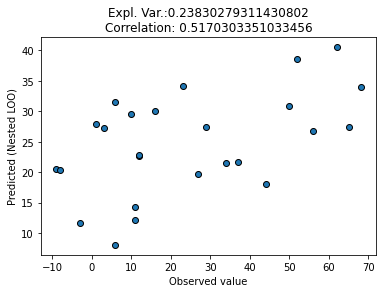

R2=0.509  R=0.714   p=0.000062  Expl. Var.: 41.0%  Expl. Var.2: 41.5%  MSE=320.587 RMSE=17.905  MAE=15.015 MedAE=11.913  R^2=0.410


/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


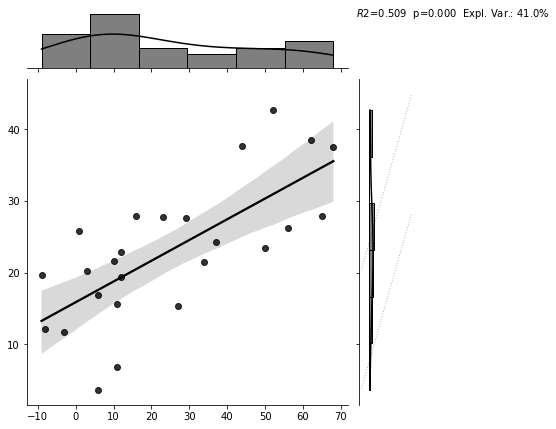

In [65]:
X_ridg = X_predictor
y_ridg = y_predictor #y_predictor

mymodel, p_grid = pipe_scale_fsel_ridge_noscaler()
#p_grid = {'fsel__k': [35], 'model__alpha': [.005]}
m, avg_model, all_models, mycrossval, myfig, nestedpredictedvals = mytrain(X_ridg, y_ridg, mymodel, p_grid,
                                                                              nested=True,
                                                                              score='neg_mean_squared_error')
myprediction = evaluate_crossval_prediction(m,X_ridg, y_ridg,outfile=[])

In [71]:
# save the model
filename = '/home/balint/CODE/Fear-conditiong-and-Rsns/data_out/finalmodel/finale_model_M1.sav'
#pickle.dump(m, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

In [67]:
# get the most important connections from our model
finalemodel = m
print('This is the main model. The connections are listed in strength order.')

zip_dict_labelnames=zip(list(labelinf['label']),list(labelinf['name']))
dict_labelnames=dict(zip_dict_labelnames)
# add global signal by hand
dict_labelnames['GlobSig'] = 'Global Signal'
#define the connections in our model, this include the short name of the connection pair and the strenght in the model
connections = pd.DataFrame(list((listoflabelpairs[i],finalemodel[1].coef_[idx]) for idx,i in enumerate(finalemodel[0].get_support(indices=True))),
                           columns=['conn','strenght'])
#print(connections.head())
print('the total number of predictive connections:'+str(len(connections)))
connections

This is the main model. The connections are listed in strength order.
the total number of predictive connections:30


,conn,strenght
0,"[CERCR1, CER6_d]",19.936245
1,"[R_CERCR2_p, L_IPlob.1]",-20.626237
2,"[CER7b_m, PRC_d.1]",-12.664019
3,"[PRC_v, R_MFgyr_a]",22.326984
4,"[CER9_d, FP]",2.825834
5,"[POsul_v, SPlob.1]",20.670183
6,"[SPlob.1, L_MFgyr_pr]",6.547995
7,"[L_DVIS_v, R_PORB]",-36.199498
8,"[R_IPsul, L_IPsul]",33.612956
9,"[R_ANGgyr, DVIS_vl]",-15.201830


In [68]:
# this part only
dict_roivalues = dict(zip(list(labelinf['roi']),list(labelinf['label'])))
#add global signal by hand
dict_roivalues[123]='GlobSig'
# we have to play around a little as the short names of certain ROIs are in the list two times because they are neighbouring areas in the MIST122 atlas.
# (e.g. the superior parietal lobule is the 1st and 76th ROI as well, but that two region anatomical coordinates are differ a bit(see the MIST122 table for detail)
for row, ind in enumerate(connections['conn']):
    if ind[0][-2:]=='.1':
        print(ind)
        connections.loc[row,'region1'] = dict_labelnames[ind[0][:-2]]
        connections.loc[row,'roival_region1'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[0][:-2]][1]
    else:
        connections.loc[row,'region1'] = dict_labelnames[ind[0]]
        connections.loc[row,'roival_region1'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[0]][0]
    if ind[1][-2:]=='.1':
        print(ind)
        connections.loc[row,'region2'] = dict_labelnames[ind[1][:-2]]
        connections.loc[row,'roival_region2'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[1][:-2]][1]
    else:
        connections.loc[row,'region2'] = dict_labelnames[ind[1]]
        connections.loc[row,'roival_region2'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[1]][0]

ordered_connections = connections.reindex(connections.strenght.abs().sort_values(ascending=False).index)
ordered_connections

['R_CERCR2_p', 'L_IPlob.1']
['CER7b_m', 'PRC_d.1']
['POsul_v', 'SPlob.1']
['SPlob.1', 'L_MFgyr_pr']
['L_IPlob.1', 'IMsul']


,conn,strenght,region1,roival_region1,region2,roival_region2
13,"[PINS_v, L_MOTnet_dl]",45.758609,POSTERIOR_INSULA_ventral,21.0,left_SOMATOMOTOR_NETWORK_dorsolateral,8.0
29,"[THAL_d, VVISnet_m]",-45.549817,THALAMUS_dorsal,31.0,VENTRAL_VISUAL_NETWORK_medial,40.0
10,"[CER7b_m, COLsul]",41.789489,CEREBELLUM_VIIb_medial,18.0,COLLATERAL_SULCUS,79.0
7,"[L_DVIS_v, R_PORB]",-36.199498,left_DORSAL_VISUAL_STREAM_ventral,50.0,right_PARS_ORBITALIS,92.0
8,"[R_IPsul, L_IPsul]",33.612956,right_INTRAPARIETAL_SULCUS,20.0,left_INTRAPARIETAL_SULCUS,74.0
25,"[PUT_p, PVISnet_dm]",-29.782826,PUTAMEN_posterior,25.0,POSTERIOR_VISUAL_NETWORK_dorsomedial,16.0
27,"[CER5, MVISnet_ad]",-29.406609,CEREBELLUM_I-V,48.0,MEDIAL_VISUAL_NETWORK_anterodorsal,19.0
26,"[L_CERCR2_a, MVISnet_ad]",28.867435,left_CEREBELLUM_CRUSII_anterior,54.0,MEDIAL_VISUAL_NETWORK_anterodorsal,19.0
21,"[L_IPlob, MDVISnet_p]",28.798373,left_INFERIOR_PARIETAL_LOBULE,4.0,MEDIODORSAL_VISUAL_NETWORK_posterior,57.0
22,"[PCcor, LVISnet_vp]",-28.120602,POSTERIOR_CINGULATE_CORTEX,24.0,LATERAL_VISUAL_NETWORK_ventroposterior,81.0
